In [1]:
from datetime import timedelta
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import json
import os

/home/dottyz/miniconda3/envs/open-data/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)

In [3]:
bikeshare_stations.sample(10)

,station_id,name,lat,lon
201,7222.0,Sunnyside - Gus Ryder Pool,43.637894,-79.454823
261,7283.0,Front St W / Bay St (South Side),43.645950,-79.378761
97,7102.0,Nelson St / Duncan St,43.648711,-79.389728
274,7299.0,Mill St / Parliament St,43.650256,-79.361630
164,7174.0,Bloor St W / Dundas St W,43.656389,-79.451667
82,7087.0,Danforth Ave / Aldridge Ave,43.684758,-79.316767
53,7055.0,Jarvis St / Carlton St,43.662070,-79.376170
108,7113.0,Parliament St / Aberdeen Ave,43.665278,-79.368333
346,7380.0,Erskine Ave / Yonge St SMART,43.711215,-79.398940
7,7009.0,King St E / Jarvis St,43.650325,-79.372287


In [4]:
# Identify the date structure used by each of the files as a dict:
#      * Key: data file name
#      * Value: [datetime format, hour difference bewteen timezone used and Eastern timezone]

date_formats = {
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}

df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(os.path.join('./data', fn))
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce') # Read the datetime in the specified format
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])                       # Convert the input time to the Easter timezone

    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)                                    # Merge the content of the file to the main DataFrame

In [5]:
df.sample(10)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
1259192,2114307,2017-10-21 17:09:18,10/21/17 17:19:19,601,NaN,Bremner Blvd / Rees St,NaN,Bathurst St / Queens Quay W,Casual
347698,1118357,2017-06-08 05:55:00,8/6/2017 10:15,1204,7173.0,Cariboo St / Rail Path,7171.0,Ontario Place Blvd / Remembrance Dr,Member
176010,918983,2017-04-18 17:07:00,18/04/2017 21:18,670,7019.0,Temperance St / Yonge St,7065.0,Dundas St E / Parliament St,Member
1337668,2202613,2017-11-06 17:09:18,11/06/17 17:13:56,278,NaN,Wellington St W / Portland St,NaN,Queen St W / Portland St,Member
1427734,2306233,2017-11-29 17:30:26,11/29/17 17:55:31,1505,NaN,Exhibition GO (Atlantic Ave),NaN,Princess St / Adelaide St E,Member
972151,1802945,2017-09-11 08:59:00,9/11/2017 9:31,1893,NaN,Lower Jarvis St / The Esplanade,NaN,Hanna Ave / Liberty St,Member
1172466,2019034,2017-10-07 10:10:46,10/07/17 10:23:24,758,NaN,HTO Park (Queens Quay W),NaN,Queen St W / York St (City Hall),Member
1441485,2321433,2017-12-03 13:11:11,12/03/17 13:15:09,238,NaN,Spadina Ave / Adelaide St W,NaN,Queen St W / Portland St,Member
553219,1349507,2017-07-14 09:04:00,7/14/2017 9:11,414,NaN,Simcoe St / Queen St W,NaN,Princess St / Adelaide St E,Member
1024304,1858900,2017-09-17 15:37:00,9/17/2017 16:00,1372,NaN,Charles St W / Balmuto St - SMART,NaN,Queen St W / Cowan Ave,Member


In [6]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# Extracts the unique station ID and name combination from the from_station and to_station columns
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [7]:
stations.sample(10)

,station_id,name
283,NaN,Lower Sherbourne St / The Esplanade
327,NaN,Spadina Ave / Sussex Ave
286,NaN,Yonge St / Harbour St
163,7183.0,Margueretta St / College St W
24,7133.0,Summerhill Station
222,NaN,Queens Quay / Yonge St
268,NaN,College St / Markham St
468,NaN,Bloor St W / Shaw Ave - SMART
317,NaN,Taddle Creek Park
353,NaN,Phoebe St / Spadina Ave


In [8]:
# Separate the stations without station IDs
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # Compare the similarity of the station without ID to each station in the API data
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # Warn if the station was not able to be matched
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))

# Remove all stations that were not matched
no_ids = no_ids.dropna()

WARN: Michael Sweet Ave / St. Patrick St station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Wellesley St / Queen's Park Cres station could not be matched to an existing station
WARN: Davenport Rd / Bedford Rd station could not be matched to an existing station
WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Woodbine Subway Green P (Cedarvale Ave) station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Roxton Rd / College St station could not be matched to an existing station
WARN: Base Station station could not be matched to an existing station
WARN: Lake Shore Blvd W / Ontario Dr(Ontario Pla

In [9]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [10]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()

df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name') and x != 'trip_stop_time']]

In [11]:
df.sample(10)

,trip_id,trip_start_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
918215,1906796,2017-09-22 19:12:00,391,Member,7049.0,Queen St W / Portland St,43.647600,-79.401500,7035.0,Queen St W / Ossington Ave,43.643975,-79.419576
636877,2238032,2017-11-14 16:41:01,737,Member,7056.0,Parliament St / Gerrard St,43.662132,-79.365680,7033.0,Union Station,43.645609,-79.380386
539172,1539361,2017-08-08 20:49:00,327,Casual,7078.0,College St / Major St,43.657600,-79.403200,7191.0,Central Tech (Harbord St),43.661975,-79.407896
572311,2106427,2017-10-20 17:03:25,356,Member,7275.0,Queen St W / James St,43.652276,-79.380701,7022.0,Simcoe St / Queen St W,43.650858,-79.387582
745600,846029,2017-03-21 11:57:00,569,Member,7020.0,Phoebe St / Spadina Ave,43.650033,-79.396555,7051.0,Wellesley St E / Yonge St Green P,43.665060,-79.383570
443572,1467341,2017-07-29 15:48:00,448,Member,7010.0,King St W / Spadina Ave,43.645323,-79.395003,7032.0,Augusta Ave / Dundas St W,43.652473,-79.401456
954002,730521,2017-01-15 02:28:00,695,Member,7070.0,25 York St (ACC/Union Station South),43.643667,-79.380414,7123.0,424 Wellington St. W,43.643834,-79.396649
908475,1953537,2017-09-28 11:23:00,326,Member,7251.0,The Royal Ontario Museum (Bloor St Entrance),43.668561,-79.394403,7025.0,Ted Rogers Way / Bloor St E,43.671293,-79.380471
230201,1132902,2017-06-10 13:12:00,1667,Casual,7037.0,Bathurst St / Dundas St W,43.652300,-79.405800,7004.0,University Ave / Elm St,43.656518,-79.389099
631145,1038364,2017-05-23 06:29:00,406,Member,7123.0,424 Wellington St. W,43.643834,-79.396649,7033.0,Union Station,43.645609,-79.380386


In [12]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06,1.443979e+06
mean,1.547715e+06,1.020235e+03,7.094254e+03,4.365383e+01,-7.939058e+01,7.093350e+03,4.365303e+01,-7.939000e+01
std,4.773673e+05,9.924367e+03,7.606454e+01,1.059573e-02,2.010674e-02,7.580636e+01,1.024664e-02,2.023239e-02
min,7.123820e+05,1.000000e+00,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.138084e+06,4.140000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939960e+01
50%,1.547850e+06,6.540000e+02,7.068000e+03,4.365282e+01,-7.938758e+01,7.067000e+03,4.365228e+01,-7.938750e+01
75%,1.957892e+06,1.019000e+03,7.158000e+03,4.366197e+01,-7.937988e+01,7.157000e+03,4.366030e+01,-7.937986e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


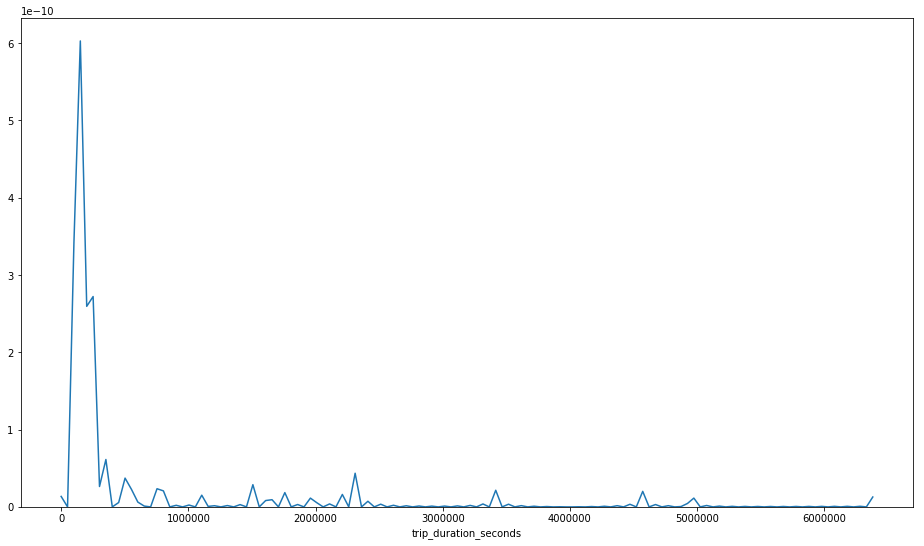

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.distplot(df['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./visualization/raw_distributions.png')

In [12]:
df.shape

(1443979, 12)

In [13]:
df = df[(df['trip_duration_seconds']>=60)]

In [14]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06,1.414475e+06
mean,1.544063e+06,1.040980e+03,7.094174e+03,4.365387e+01,-7.939057e+01,7.093264e+03,4.365306e+01,-7.938997e+01
std,4.795400e+05,1.002629e+04,7.596690e+01,1.057742e-02,2.004762e-02,7.571064e+01,1.022364e-02,2.017457e-02
min,7.123820e+05,6.000000e+01,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.129728e+06,4.280000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939960e+01
50%,1.542682e+06,6.650000e+02,7.068000e+03,4.365324e+01,-7.938758e+01,7.067000e+03,4.365228e+01,-7.938750e+01
75%,1.957804e+06,1.029000e+03,7.158000e+03,4.366197e+01,-7.937988e+01,7.157000e+03,4.366041e+01,-7.937986e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


In [15]:
df.shape

(1414475, 12)

In [16]:
q1 = df['trip_duration_seconds'].quantile(0.25)
q3 = df['trip_duration_seconds'].quantile(0.75)
interquartile_range = q3 - q1

df = df[~((df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range))|(df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

In [17]:
df.shape

(1332419, 12)

In [15]:
df.to_csv('./data/bikeshare_ridership.csv', index=False)